In [3]:
# import pakages
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# get training and testing data and split them to input and output

# get training data
train = pd.read_csv('sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
train_tensor = torch.tensor(train.values)
# split input from output
(train_tensor_y, train_tensor_x) = torch.split(train_tensor, [1, train_tensor.size()[1]-1], dim=1)
train_tensor_y = torch.flatten(train_tensor_y)
print("training input: ", train_tensor_x)
print("training output: ", train_tensor_y)

# get testing data
test = pd.read_csv('sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')
test_tensor = torch.tensor(test.values)
# split input from output
(test_tensor_y, test_tensor_x) = torch.split(test_tensor, [1, test_tensor.size()[1]-1], dim=1)
test_tensor_y = torch.flatten(test_tensor_y)
print("testing input: ", test_tensor_x)
print("testing output: ", test_tensor_y)

training input:  tensor([[107, 118, 127,  ..., 204, 203, 202],
        [155, 157, 156,  ..., 103, 135, 149],
        [187, 188, 188,  ..., 195, 194, 195],
        ...,
        [174, 174, 174,  ..., 202, 200, 200],
        [177, 181, 184,  ...,  64,  87,  93],
        [179, 180, 180,  ..., 205, 209, 215]])
training output:  tensor([ 3,  6,  2,  ..., 18, 17, 23])
testing input:  tensor([[149, 149, 150,  ..., 112, 120, 107],
        [126, 128, 131,  ..., 184, 182, 180],
        [ 85,  88,  92,  ..., 225, 224, 222],
        ...,
        [190, 191, 190,  ..., 211, 209, 208],
        [201, 205, 208,  ...,  67,  70,  63],
        [173, 174, 173,  ..., 195, 193, 192]])
testing output:  tensor([ 6,  5, 10,  ...,  2,  4,  2])


In [5]:
# mapping the alphabet
alphabets = {
    0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:"f", 6:'g', 7:'h', 8:'i',
    9:'j', 10:'k', 11:'l', 12:'m', 13:'n', 14:'o', 15:'p', 16:'q',
    17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25:'z'
}

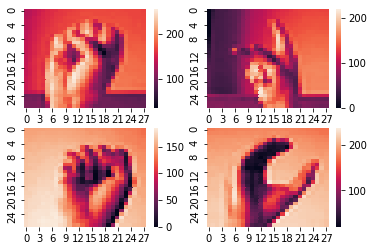

In [6]:

pixels = train_tensor_x[10].reshape(28, 28)
plt.subplot(221)
sns.heatmap(data=pixels)

pixels = train_tensor_x[11].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)

pixels = train_tensor_x[20].reshape(28, 28)
plt.subplot(223)
sns.heatmap(data=pixels)

pixels = train_tensor_x[32].reshape(28, 28)
plt.subplot(224)
sns.heatmap(data=pixels)

In [7]:
def reshape_to_2d(data, dim):
    reshaped = []
    for i in data:
        reshaped.append(i.reshape(1, dim, dim))

    return reshaped

In [8]:
epochs = 50
batch_size = 100
learning_rate = 0.001

In [9]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation, 784 is the size of each image
        self.hidden1 = nn.Linear(784, 512)
        # hidden layer number 2
        self.hidden2 = nn.Linear(512, 256)
        # hidden layer number 3
        self.hidden3 = nn.Linear(256, 128)
        # hidden layer number 4
        self.hidden4 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(64, 27)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden1(x)
        x = self.sigmoid(x)
        x = self.hidden2(x)
        x = self.sigmoid(x)
        x = self.hidden3(x)
        x = self.sigmoid(x)
        x = self.hidden4(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x
    def test(self, predictions, labels):
        
        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        print("Correct predictions: %5d / %5d (%5f)" % (correct, len(predictions), acc))
        
    
    def evaluate(self, predictions, labels):
                
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        return(acc)


In [10]:
net = Network()
print(net)

Network(
  (hidden1): Linear(in_features=784, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=256, bias=True)
  (hidden3): Linear(in_features=256, out_features=128, bias=True)
  (hidden4): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=27, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)


In [11]:
optimizer = optim.Adam(net.parameters(), learning_rate)
loss_func = nn.CrossEntropyLoss()

In [12]:
loss_log = []
acc_log = []

for e in range(epochs):
    for i in range(0, train_tensor_x.shape[0], batch_size):
        x_mini = train_tensor_x[i:i + batch_size] 
        y_mini = train_tensor_y[i:i + batch_size] 
        
        optimizer.zero_grad()
        net_out = net(Variable(x_mini).float())
        
        loss = loss_func(net_out, Variable(y_mini))
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(
                net.evaluate(torch.max(net(Variable(test_tensor_x[:500].float())).data, 1)[1], test_tensor_y[:500])
            )
        
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 3.285077
Epoch: 2 - Loss: 3.284703
Epoch: 3 - Loss: 3.284563
Epoch: 4 - Loss: 3.284495
Epoch: 5 - Loss: 3.284467
Epoch: 6 - Loss: 3.284460
Epoch: 7 - Loss: 3.284463
Epoch: 8 - Loss: 3.284472
Epoch: 9 - Loss: 3.284482
Epoch: 10 - Loss: 3.284497
Epoch: 11 - Loss: 3.284526
Epoch: 12 - Loss: 3.284557
Epoch: 13 - Loss: 3.284570
Epoch: 14 - Loss: 3.284571
Epoch: 15 - Loss: 3.284571
Epoch: 16 - Loss: 3.284575
Epoch: 17 - Loss: 3.284580
Epoch: 18 - Loss: 3.284590
Epoch: 19 - Loss: 3.284603
Epoch: 20 - Loss: 3.284623
Epoch: 21 - Loss: 3.284616
Epoch: 22 - Loss: 3.284586
Epoch: 23 - Loss: 3.284573
Epoch: 24 - Loss: 3.284569
Epoch: 25 - Loss: 3.284565
Epoch: 26 - Loss: 3.284561
Epoch: 27 - Loss: 3.284558
Epoch: 28 - Loss: 3.284555
Epoch: 29 - Loss: 3.284556
Epoch: 30 - Loss: 3.284557
Epoch: 31 - Loss: 3.284558
Epoch: 32 - Loss: 3.284558
Epoch: 33 - Loss: 3.284558
Epoch: 34 - Loss: 3.284561
Epoch: 35 - Loss: 3.284562
Epoch: 36 - Loss: 3.284563
Epoch: 37 - Loss: 3.284564
Epoch: 38 

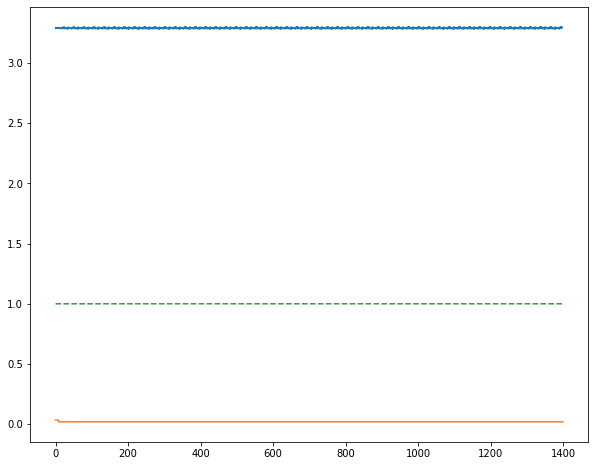

In [13]:
%matplotlib inline

plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])
plt.plot(acc_log)
plt.plot(np.ones(len(acc_log)), linestyle='dashed')